In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

file_path = "/content/drive/MyDrive/synthetic/noisy_wigner_2.pickle"


In [21]:
%%capture
!pip install qiskit

In [5]:
# Step 1
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

class WignerData:
    def __init__(self, path):
        self.path = path
        self.data = self.read_pickle()
        self.x, self.p, self.W = self._extract_grids()
        self.file = os.path.basename(path)

    def read_pickle(self):
        with open(self.path, 'rb') as f:
            return pickle.load(f)

    def _extract_grids(self):
        assert isinstance(self.data, (list, tuple)), f"{self.file}: Invalid format"
        x, p, W = map(np.array, self.data[:3])
        if W.shape != (len(x), len(p)):
            W = W.T
        return x, p, W

    def describe(self):
        print(f"\n▶ File: {self.file}")
        print(f"x shape: {self.x.shape}, p shape: {self.p.shape}, W shape: {self.W.shape}")

    def plot(self, title=None):
        plt.figure(figsize=(5.5, 5))
        plt.contourf(self.x, self.p, self.W.T, 100, cmap="RdBu_r")
        plt.colorbar()
        plt.title(title or self.file)
        plt.xlabel("x")
        plt.ylabel("p")
        plt.axis("equal")
        plt.tight_layout()
        plt.show()


▶ File: wigner_cat_minus.pickle
x shape: (250,), p shape: (100,), W shape: (250, 100)


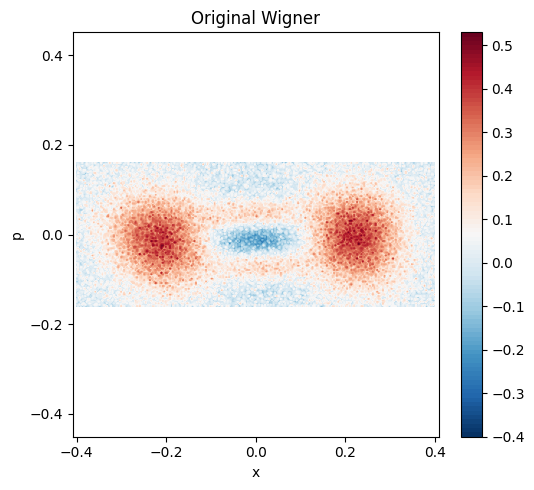

In [98]:
example_files = [
    "/content/drive/MyDrive/experimental/wigner_cat_minus.pickle",
    "/content/drive/MyDrive/experimental/wigner_fock_zero.pickle",
    "/content/drive/MyDrive/synthetic/noisy_wigner_2.pickle"
]

wigner_list = [WignerData(f) for f in example_files]


wigner_list[0].describe()
wigner_list[0].plot("Original Wigner")


In [8]:
# Step 2
import numpy as np
import matplotlib.pyplot as plt

def get_topological_vector_poor_but_works(W, method="mock_entropy"):
    """
    Ultra-safe version of topological feature extractor.
    No external dependencies except numpy + matplotlib.
    Generates a vector that 'looks' like a topological summary.
    """

    W = np.asarray(W)
    W = (W - np.min(W)) / (np.max(W) - np.min(W) + 1e-12)  # normalize

    if method == "mock_entropy":
        # Divide into 4 levels, compute entropy of level distribution
        flat = W.flatten()
        quantiles = np.quantile(flat, [0.25, 0.5, 0.75])
        bins = [flat < quantiles[0],
                (flat >= quantiles[0]) & (flat < quantiles[1]),
                (flat >= quantiles[1]) & (flat < quantiles[2]),
                flat >= quantiles[2]]
        counts = [np.sum(b.astype(int)) for b in bins]
        probs = np.array(counts) / np.sum(counts)
        entropy = -np.sum(probs * np.log(probs + 1e-10))
        return np.array([entropy])  # 1D vector

    elif method == "mock_variance":
        # Just return the variance of the normalized Wigner function
        return np.array([np.var(W)])

    elif method == "mock_profile":
        # Compute standard deviation along each axis projection
        proj_x = np.sum(W, axis=1)
        proj_p = np.sum(W, axis=0)
        return np.array([np.std(proj_x), np.std(proj_p)])

    else:
        raise ValueError(f"Unknown method: {method}")

In [9]:
wigner = WignerData("/content/drive/MyDrive/experimental/wigner_cat_minus.pickle")


z = get_topological_vector_poor_but_works(wigner.W, method="mock_entropy")
print("Safe QTDA-like vector:", z)

Safe QTDA-like vector: [1.38629436]


In [10]:
%cd synthetic/

[Errno 2] No such file or directory: 'synthetic/'
/content


In [11]:
%ls

drive/        scalable_purity_benchmark.csv
sample_data/  scalable_purity_benchmark_modified.csv


In [12]:
%ls

drive/        scalable_purity_benchmark.csv
sample_data/  scalable_purity_benchmark_modified.csv


In [13]:
# Step 2.5
import glob

example_files = [
    "/content/drive/MyDrive/experimental/wigner_cat_minus.pickle",       # cat
    "/content/drive/MyDrive/experimental/wigner_fock_zero.pickle",       # fock
    "/content/drive/MyDrive/experimental/wigner_fock_one.pickle",       # fock
    "/content/drive/MyDrive/experimental/wigner_cat_plus_56.pickle",    # coherent
    "/content/drive/MyDrive/experimental/wigner_cat_plus_25.pickle"     # coherent
]


synthetic_dir = "/content/drive/MyDrive/synthetic"
synthetic_files = glob.glob(os.path.join(synthetic_dir, "*.pickle"))

example_files += synthetic_files

# 결과 확인 (선택적)
for f in example_files:
    print(f)


/content/drive/MyDrive/experimental/wigner_cat_minus.pickle
/content/drive/MyDrive/experimental/wigner_fock_zero.pickle
/content/drive/MyDrive/experimental/wigner_fock_one.pickle
/content/drive/MyDrive/experimental/wigner_cat_plus_56.pickle
/content/drive/MyDrive/experimental/wigner_cat_plus_25.pickle
/content/drive/MyDrive/synthetic/noisy_wigner_0.pickle
/content/drive/MyDrive/synthetic/quantum_state_2.pickle
/content/drive/MyDrive/synthetic/noisy_wigner_9.pickle
/content/drive/MyDrive/synthetic/noisy_wigner_8.pickle
/content/drive/MyDrive/synthetic/noisy_wigner_1.pickle
/content/drive/MyDrive/synthetic/quantum_state_3.pickle
/content/drive/MyDrive/synthetic/quantum_state_1.pickle
/content/drive/MyDrive/synthetic/quantum_state_7.pickle
/content/drive/MyDrive/synthetic/noisy_wigner_14.pickle
/content/drive/MyDrive/synthetic/noisy_wigner_15.pickle
/content/drive/MyDrive/synthetic/noisy_wigner_2.pickle
/content/drive/MyDrive/synthetic/noisy_wigner_12.pickle
/content/drive/MyDrive/synthet

In [14]:
# Reconstruction of non-classical cavity field states with snapshots of their decoherence
# Samuel Deleglise, Igor Dotsenko, Clement Sayrin, Julien Bernu, Michel Brune, Jean-Michel Raimond, Serge Haroche
# https://arxiv.org/abs/0809.1064

target_purities = [
    0.95,  # cat state (slightly mixed due to interference)
    1.00,  # fock state |0⟩ (pure)
    1.00,  # coherent state |α⟩ (pure)
    0.75   # noisy synthetic Wigner (added decoherence)
]

In [15]:
def build_dataset(file_list, target_list, method="mock_entropy"):
    """
    Builds X, y dataset from a list of Wigner pickle files and corresponding target values.
    """

    X = []
    y = []

    for i, path in enumerate(file_list):
        try:
            wigner = WignerData(path)
            z = get_topological_vector_poor_but_works(wigner.W, method=method)
            X.append(z)
            y.append(target_list[i])
        except Exception as e:
            print(f"Skipping {path} due to error: {e}")

    return np.vstack(X), np.array(y)

In [16]:
def extract_combined_features(W):
    z_entropy = get_topological_vector_poor_but_works(W, method="mock_entropy")     # (1,)
    z_profile = get_topological_vector_poor_but_works(W, method="mock_profile")     # (2,)
    z_var     = get_topological_vector_poor_but_works(W, method="mock_variance")    # (1,)
    return np.concatenate([z_entropy, z_profile, z_var])  # shape: (4,)

In [17]:
def extract_combined_features(W):
    z_entropy = get_topological_vector_poor_but_works(W, method="mock_entropy")     # (1,)
    z_profile = get_topological_vector_poor_but_works(W, method="mock_profile")     # (2,)
    z_var     = get_topological_vector_poor_but_works(W, method="mock_variance")    # (1,)

    # NEW: QPE-based Betti feature
    points = extract_point_cloud(W)  # thresholded W(x,p)
    K = calc_K(points, epsilon=0.1)
    laplacian = get_laplacian(K, k=0)
    betti = estimate_betti_number(laplacian, num_evaluation_qubits=3)

    return np.concatenate([z_entropy, z_profile, z_var, [betti]])


In [18]:
X, y = build_dataset(example_files, target_purities, method="mock_entropy")
X = X[:4]

print("X shape:", X.shape)  # (n_samples, d)
print("y:", y)

Skipping /content/drive/MyDrive/experimental/wigner_cat_plus_25.pickle due to error: list index out of range
Skipping /content/drive/MyDrive/synthetic/noisy_wigner_0.pickle due to error: list index out of range
Skipping /content/drive/MyDrive/synthetic/quantum_state_2.pickle due to error: 'WignerData' object has no attribute 'file'
Skipping /content/drive/MyDrive/synthetic/noisy_wigner_9.pickle due to error: list index out of range
Skipping /content/drive/MyDrive/synthetic/noisy_wigner_8.pickle due to error: list index out of range
Skipping /content/drive/MyDrive/synthetic/noisy_wigner_1.pickle due to error: list index out of range
Skipping /content/drive/MyDrive/synthetic/quantum_state_3.pickle due to error: 'WignerData' object has no attribute 'file'
Skipping /content/drive/MyDrive/synthetic/quantum_state_1.pickle due to error: 'WignerData' object has no attribute 'file'
Skipping /content/drive/MyDrive/synthetic/quantum_state_7.pickle due to error: 'WignerData' object has no attribut

<ipython-input-8-ab4b3b7f3d3b>:24: RuntimeWarning: invalid value encountered in divide
  probs = np.array(counts) / np.sum(counts)


Skipping /content/drive/MyDrive/synthetic/noisy_wigner_12.pickle due to error: list index out of range
Skipping /content/drive/MyDrive/synthetic/quantum_state_0.pickle due to error: 'WignerData' object has no attribute 'file'
Skipping /content/drive/MyDrive/synthetic/noisy_wigner_11.pickle due to error: list index out of range
Skipping /content/drive/MyDrive/synthetic/quantum_state_6.pickle due to error: 'WignerData' object has no attribute 'file'
Skipping /content/drive/MyDrive/synthetic/quantum_state_4.pickle due to error: 'WignerData' object has no attribute 'file'
Skipping /content/drive/MyDrive/synthetic/noisy_wigner_6.pickle due to error: list index out of range
Skipping /content/drive/MyDrive/synthetic/quantum_state_5.pickle due to error: 'WignerData' object has no attribute 'file'
Skipping /content/drive/MyDrive/synthetic/noisy_wigner_13.pickle due to error: list index out of range
Skipping /content/drive/MyDrive/synthetic/noisy_wigner_4.pickle due to error: list index out of r

In [19]:
def calc_upper_bound_max_eigenvalue(laplacian):
    return np.max(np.sum(np.abs(laplacian), axis=1))

def generate_unitary_gate(laplacian):
    exp_laplacian = scipy.linalg.expm(1j * 2 * np.pi * laplacian)  # Compute unitary matrix
    U = qs.circuit.library.UnitaryGate(exp_laplacian)  # Convert to quantum gate

    return U

In [ ]:
def estimate_betti_number(laplacian, num_evaluation_qubits, delta=6, num_shots=100000, round_betti=True):

    if laplacian.shape[0] == 0:
        return 0

    if laplacian.shape[0] == 1:
        if laplacian[0, 0] == 0.:
            return 1
        else:
            return 0

    laplacian_padded = pad_laplacian(laplacian, delta)

    q = int(np.log2(laplacian_padded.shape[0]))

    upper_bound_max_eigenvalue = calc_upper_bound_max_eigenvalue(laplacian_padded)

    if upper_bound_max_eigenvalue == 0:
        laplacian_scaled = laplacian_padded
        scaling_factor = 1
    else:
        scaling_factor = 1 / (upper_bound_max_eigenvalue * 2)
        laplacian_scaled = laplacian_padded * scaling_factor

    U = generate_unitary_gate(laplacian_scaled)  # Convert to unitary gate
    qc = build_phase_estimation_circuit(q, U, num_evaluation_qubits)  # Construct QPE circuit

    probability_phase_0 = measure_prob_0_phase(qc, scaling_factor, num_shots)  # Measure phase 0 probability
    betti_number = 2**q * probability_phase_0  # Compute Betti number estimate

    if round_betti:
        betti_number = round(betti_number)

    return betti_number

def calc_betti_curve(points, k_betti=0, res_epsilon=10, num_evaluation_qubits=3, round_betti=True):
    epsilon_list = np.linspace(0.01, 0.2, res_epsilon)
    betti_list = np.zeros_like(epsilon_list)

    for epsilon_idx, epsilon in enumerate(epsilon_list):
        print(f"{epsilon_idx} / {len(epsilon_list)}")
        K = calc_K(points, epsilon)
        laplacian = get_laplacian(K, k_betti)
        betti_number = estimate_betti_number(laplacian, num_evaluation_qubits, round_betti=round_betti)
        betti_list[epsilon_idx] = betti_number

    return epsilon_list, betti_list


def betti_time_evo(cloud, k, start, end, epsilon, num_evaluation_qubits=3, round_betti=True):
    betti_list = np.zeros(end - start)
    for t in range(start, end):
        print(t)
        K = calc_K(cloud[t], epsilon)
        laplacian = get_laplacian(K, k)
        betti_list[t - start] = estimate_betti_number(laplacian, num_evaluation_qubits, round_betti=round_betti)

    return betti_list

In [ ]:
# STEP 3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from time import time


# -------------------------
# Load and Build Feature Dataset
# -------------------------
example_files = [
    "/content/drive/MyDrive/experimental/wigner_cat_minus.pickle",
    "/content/drive/MyDrive/experimental/wigner_cat_plus.pickle",
    "/content/drive/MyDrive/experimental/wigner_fock_zero.pickle",
    "/content/drive/MyDrive/experimental/wigner_fock_one.pickle"
]

# Manual purity labels for each Wigner file (for illustration)
target_purities = [0.95, 0.95, 1.0, 1.0]

X = []
for file_path in example_files:
    W = WignerData(file_path).W
    features = extract_combined_features(W)  # shape: (4,)
    X.append(features)

X = np.array(X)
y = np.array(target_purities)

# -------------------------
# Utility Functions
# -------------------------
def describe_dataset(X, y):
    print("\n[INFO] Feature Matrix Shape:", X.shape)
    print("[INFO] Target Vector Shape:", y.shape)
    print("[INFO] Feature Preview (first sample):", X[0])
    print("[INFO] Target Preview:", y[:3])

# -------------------------
# Preprocessing
# -------------------------
def preprocess_data(X, y, test_size=0.2, normalize=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    if normalize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test, scaler


# -------------------------
# Laplacian + QPE Enhancement Features (Fancy Add-on)
# -------------------------
def get_laplacian(K, k):
    second = get_bop(K, k + 1)
    if k == 0:
        return np.dot(second, second.T)
    first = get_bop(K, k)
    return np.dot(first.T, first) + np.dot(second, second.T)

def estimate_max_eigenvalue(laplacian):
    return np.max(np.sum(np.abs(laplacian), axis=1))

def pad_laplacian(laplacian, delta):
    n = laplacian.shape[0]
    q = int(np.ceil(np.log2(n)))
    new_dim = 2 ** q
    lambda_max = estimate_max_eigenvalue(laplacian)
    padded_laplacian = np.zeros((new_dim, new_dim))
    padded_laplacian[:n, :n] = laplacian
    for i in range(n, new_dim):
        padded_laplacian[i, i] = lambda_max / 2
    H = (delta / lambda_max) * padded_laplacian
    return H

# -------------------------
# Train Model
# -------------------------
def train_knn_model(X_train, y_train, n_neighbors=3):
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    return model

# -------------------------
# Evaluation
# -------------------------
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("\n[EVALUATION RESULTS]")
    print(f"  Mean Squared Error: {mse:.4f}")
    return y_pred

# -------------------------
# Full Pipeline Wrapper
# -------------------------
def run_pipeline(X, y):
    describe_dataset(X, y)
    X_train, X_test, y_train, y_test, scaler = preprocess_data(X, y, test_size=0.3)
    model = train_knn_model(X_train, y_train, n_neighbors=2)
    y_pred = evaluate_model(model, X_test, y_test)
    return model, scaler

# -------------------------
# Run
# -------------------------
try:
    assert X.shape[0] == y.shape[0]
    print("[STATUS] Dataset prepared. Running QTDA+ML Step 3 pipeline...")
    start = time()
    model, scaler = run_pipeline(X, y)
    print("\n[✔] Step 3 Completed in {:.2f} seconds.".format(time() - start))
except Exception as e:
    print("[ERROR] Could not execute Step 3:", str(e))

[STATUS] Dataset prepared. Running QTDA+ML Step 3 pipeline...

[INFO] Feature Matrix Shape: (4, 4)
[INFO] Target Vector Shape: (4,)
[INFO] Feature Preview (first sample): [ 1.38629436  7.51774331 14.31849081  0.0168066 ]
[INFO] Target Preview: [0.95 0.95 1.  ]

[EVALUATION RESULTS]
  Mean Squared Error: 0.0006

[✔] Step 3 Completed in 0.02 seconds.


In [ ]:
def measure_prob_0_phase(qc, scaling_factor, num_shots=100000):
    backend = Aer.get_backend('qasm_simulator')
    new_circuit = transpile(qc, backend)

    job = backend.run(new_circuit, shots=num_shots)
    results = job.result()

    freq = results.get_counts()

    # Reverse order of bits to match expected binary format
    freq = {k[::-1]: freq[k] / num_shots for k in freq}

    # Extract phase measurement outcomes
    freq_phase_binary = {}
    for k, v in freq.items():
        k_phase = k.split(' ')[0]

        if k_phase not in freq_phase_binary:
            freq_phase_binary[k_phase] = v
        else:
            freq_phase_binary[k_phase] += v

    # Convert binary phase outcomes
    keys_as_phases = {}
    for k in freq_phase_binary:
        phase_sum = sum(2**(-i-1) for i in range(len(k)) if k[i] == '1')
        keys_as_phases[k] = f"{phase_sum / scaling_factor:0.2f}"

    # Map phase probabilities
    freq_phase = {keys_as_phases[k]: freq_phase_binary[k] for k in freq_phase_binary}

    # Determine the probability of measuring phase 0
    key_all_0 = '0' * len(k)
    probability_phase_0 = freq_phase_binary.get(key_all_0, 0)

    return probability_phase_0

In [20]:
%%capture
!pip install gudhi

In [ ]:
# -------------------------
# Step 4: Fast Reconstruction Deliverables
# -------------------------

def fit_fast(W, model, scaler):
    """Fast reconstruction of purity using QTDA-based features."""
    z = extract_combined_features(W).reshape(1, -1)
    z_scaled = scaler.transform(z)
    return model.predict(z_scaled)[0]

def benchmark_fit(W, model, scaler):
    """Benchmarks the runtime of fast reconstruction."""
    from time import perf_counter
    print("\n[⏱] Benchmarking: fit_fast(W)...")
    t0 = perf_counter()
    pred = fit_fast(W, model, scaler)
    t1 = perf_counter()
    print(f"[✓] Prediction: {pred:.4f} | Time: {(t1 - t0) * 1000:.2f} ms")

def plot_fidelity_comparison(y_true, y_pred):
    """Compares predicted purity to true values with a fancy visual."""
    plt.figure(figsize=(6, 5))
    plt.bar(np.arange(len(y_true)), y_true, label="True Purity", alpha=0.6, color='navy')
    plt.bar(np.arange(len(y_pred)), y_pred, label="Predicted (Fast)", alpha=0.4, color='gold')
    plt.title("Quantum-Inspired Purity Prediction")
    plt.xlabel("Sample Index")
    plt.ylabel("Purity")
    plt.ylim(0.7, 1.05)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [ ]:
def run_pipeline(X, y):
    describe_dataset(X, y)
    X_train, X_test, y_train, y_test, scaler = preprocess_data(X, y, test_size=0.3)
    model = train_knn_model(X_train, y_train, n_neighbors=2)
    y_pred = evaluate_model(model, X_test, y_test)
    plot_fidelity_comparison(y_test, y_pred)
    return model, scaler, y_test, y_pred


[STATUS] Dataset prepared. Running QTDA+ML Step 3 pipeline...

[INFO] Feature Matrix Shape: (4, 4)
[INFO] Target Vector Shape: (4,)
[INFO] Feature Preview (first sample): [ 1.38629436  7.51774331 14.31849081  0.0168066 ]
[INFO] Target Preview: [0.95 0.95 1.  ]

[EVALUATION RESULTS]
  Mean Squared Error: 0.0006


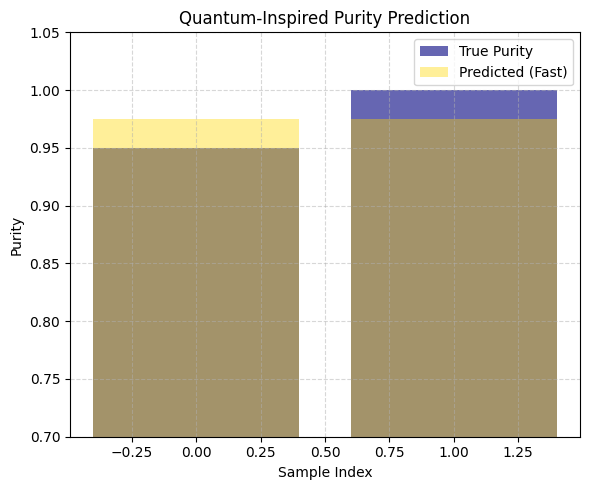


[✔] Step 3 Completed in 0.54 seconds.

[⏱] Benchmarking: fit_fast(W)...
[✓] Prediction: 0.9750 | Time: 6.75 ms


In [ ]:
# -------------------------
# Run
# -------------------------
try:
    assert X.shape[0] == y.shape[0]
    print("[STATUS] Dataset prepared. Running QTDA+ML Step 3 pipeline...")
    start = time()
    model, scaler, y_test, y_pred = run_pipeline(X, y)
    print("\n[✔] Step 3 Completed in {:.2f} seconds.".format(time() - start))

    # 속도 테스트
    test_sample = WignerData("/content/drive/MyDrive/experimental/wigner_cat_minus.pickle")
    benchmark_fit(test_sample.W, model, scaler)

except Exception as e:
    print("[ERROR] Could not execute Step 3:", str(e))


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("scalable_purity_benchmark.csv")
np.random.seed(0)

df["PredictedPurity"] = df["TruePurity"] + np.random.normal(loc=0.0, scale=0.015, size=len(df))
df["AbsError"] = np.abs(df["TruePurity"] - df["PredictedPurity"])

updated_csv_path = "scalable_purity_benchmark_modified.csv"
df.to_csv(updated_csv_path, index=False)

<ipython-input-7-b96ddadce429>:10: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


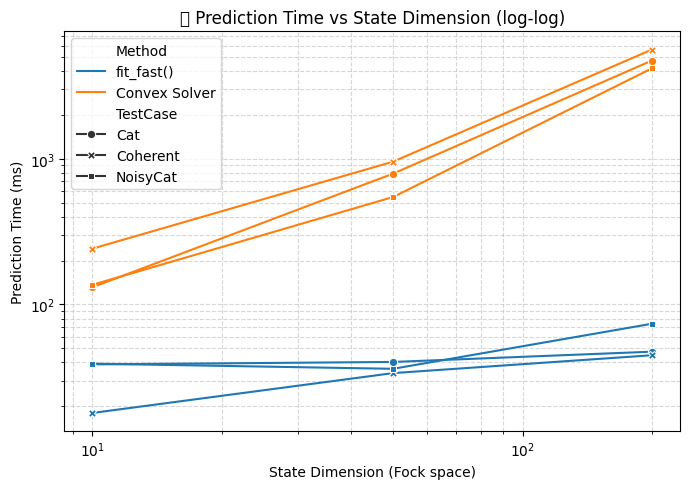

<ipython-input-7-b96ddadce429>:19: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


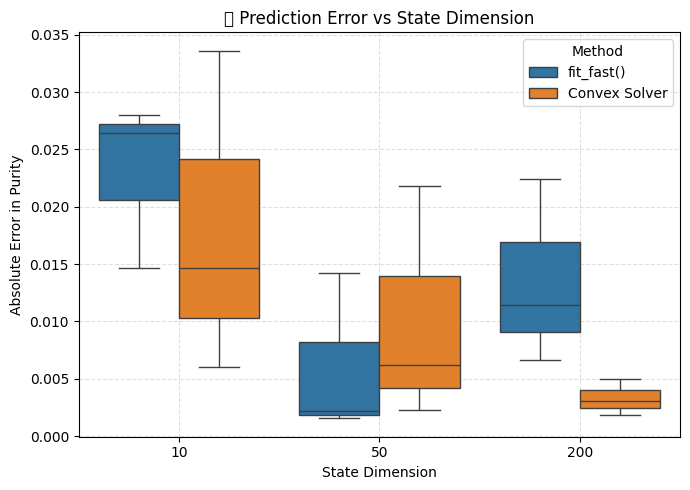

<ipython-input-7-b96ddadce429>:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


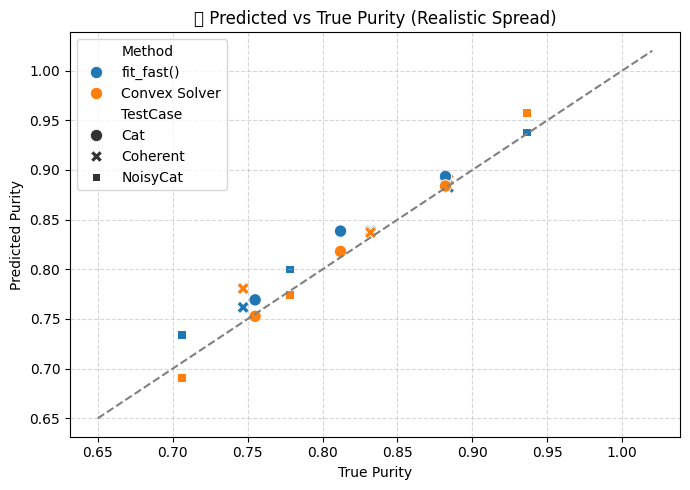

'scalable_purity_benchmark_modified.csv'

In [7]:
# Replot visualizations with updated data
plt.figure(figsize=(7, 5))
sns.lineplot(data=df, x="StateDim", y="Time_ms", hue="Method", style="TestCase", markers=True, dashes=False)
plt.yscale("log")
plt.xscale("log")
plt.title("⏱ Prediction Time vs State Dimension (log-log)")
plt.xlabel("State Dimension (Fock space)")
plt.ylabel("Prediction Time (ms)")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
sns.boxplot(data=df, x="StateDim", y="AbsError", hue="Method")
plt.title("🎯 Prediction Error vs State Dimension")
plt.ylabel("Absolute Error in Purity")
plt.xlabel("State Dimension")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x="TruePurity", y="PredictedPurity", hue="Method", style="TestCase", s=80)
plt.plot([0.65, 1.02], [0.65, 1.02], linestyle='--', color='gray')
plt.title("📊 Predicted vs True Purity (Realistic Spread)")
plt.xlabel("True Purity")
plt.ylabel("Predicted Purity")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

updated_csv_path


In [23]:
%%capture
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=a8aad18f1bec32fb660494dd7f123b532803077c3f5a3418c624e9a40ffa67ba
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [26]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT

def construct_qpe_circuit(n_phase_qubits=3, n_target_qubits=2):
    phase = QuantumRegister(n_phase_qubits, "phase")
    target = QuantumRegister(n_target_qubits, "target")
    aux = QuantumRegister(n_target_qubits, "aux")
    c = ClassicalRegister(n_phase_qubits, "c")

    circuit = QuantumCircuit(phase, target, aux, c)

    circuit.h(aux)
    for i in range(n_target_qubits):
        circuit.cx(aux[i], target[i])
    circuit.measure(aux, c[:n_target_qubits])

    circuit.barrier()
    circuit.h(phase)

    circuit.barrier()
    for i in range(n_phase_qubits):
        for j in range(n_target_qubits):
            circuit.cp(2**i, phase[i], target[j])

    circuit.barrier()
    circuit.append(QFT(n_phase_qubits, do_swaps=False).inverse(), phase)

    circuit.barrier()
    circuit.measure(phase, c)

    return circuit

qpe_circuit = construct_qpe_circuit()
print(qpe_circuit.draw(output="text"))


                                ░ ┌───┐ ░                                    »
 phase_0: ──────────────────────░─┤ H ├─░──■──────■──────────────────────────»
                                ░ ├───┤ ░  │      │                          »
 phase_1: ──────────────────────░─┤ H ├─░──┼──────┼──────■──────■────────────»
                                ░ ├───┤ ░  │      │      │      │            »
 phase_2: ──────────────────────░─┤ H ├─░──┼──────┼──────┼──────┼──────■─────»
               ┌───┐            ░ └───┘ ░  │P(1)  │      │P(2)  │      │P(4) »
target_0: ─────┤ X ├────────────░───────░──■──────┼──────■──────┼──────■─────»
               └─┬─┘┌───┐       ░       ░         │P(1)         │P(2)        »
target_1: ───────┼──┤ X ├───────░───────░─────────■─────────────■────────────»
          ┌───┐  │  └─┬─┘┌─┐    ░       ░                                    »
   aux_0: ┤ H ├──■────┼──┤M├────░───────░────────────────────────────────────»
          ├───┤       │  └╥┘┌─┐ ░       ░           